<a href="https://colab.research.google.com/github/Rafiquekuwari/machine_learning_tasks/blob/main/Machine_Learning_Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from imblearn.over_sampling import SMOTE


# Load & Explore the Dataset

In [13]:
# Load Titanic dataset
data = sns.load_dataset('titanic')

# Exploratory Data Analysis (EDA)
print("Initial Data Info:")
print(data.info())
print("Initial Data Description:")
print(data.describe())

# Check for missing values
missing_values = data.isnull().sum()
print("Missing values before handling:\n", missing_values)


Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None
Initial Data Description:
         survived      pclass

# Data Cleaning & Preprocessing

In [14]:
# Dropping columns with too many missing values and irrelevant features
columns_to_drop = [col for col in data.columns if missing_values[col] > (0.4 * len(data))] + ['alive']
print("Dropped columns:", columns_to_drop)  # Print dropped columns
data.drop(columns=columns_to_drop, axis=1, inplace=True)
# Handle missing values using imputation
imputer = SimpleImputer(strategy='most_frequent')
data[['age', 'embarked']] = imputer.fit_transform(data[['age', 'embarked']])

# Verify missing values are handled
print("Missing values after imputation:\n", data.isnull().sum())


Dropped columns: ['deck', 'alive']
Missing values after imputation:
 survived       0
pclass         0
sex            0
age            0
sibsp          0
parch          0
fare           0
embarked       0
class          0
who            0
adult_male     0
embark_town    2
alone          0
dtype: int64


# Handle Outliers Using IQR

In [15]:
# Check before outlier removal
print("Data before outlier removal:\n", data.describe())
# Detect and remove outliers
numeric_cols = data.select_dtypes(include=[np.number]).columns
Q1 = data[numeric_cols].quantile(0.25)
Q3 = data[numeric_cols].quantile(0.75)
IQR = Q3 - Q1
outlier_mask = (data[numeric_cols] < (Q1 - 1.5 * IQR)) | (data[numeric_cols] > (Q3 + 1.5 * IQR))
data = data[~outlier_mask.any(axis=1)]

# Check after outlier removal
print("Data after outlier removal:\n", data.describe())


Data before outlier removal:
          survived      pclass       sibsp       parch        fare
count  891.000000  891.000000  891.000000  891.000000  891.000000
mean     0.383838    2.308642    0.523008    0.381594   32.204208
std      0.486592    0.836071    1.102743    0.806057   49.693429
min      0.000000    1.000000    0.000000    0.000000    0.000000
25%      0.000000    2.000000    0.000000    0.000000    7.910400
50%      0.000000    3.000000    0.000000    0.000000   14.454200
75%      1.000000    3.000000    1.000000    0.000000   31.000000
max      1.000000    3.000000    8.000000    6.000000  512.329200
Data after outlier removal:
          survived      pclass       sibsp  parch        fare
count  607.000000  607.000000  607.000000  607.0  607.000000
mean     0.294893    2.462932    0.189456    0.0   15.226413
std      0.456371    0.758794    0.436027    0.0   12.616712
min      0.000000    1.000000    0.000000    0.0    0.000000
25%      0.000000    2.000000    0.000000 

# Encoding Categorical Variables

In [16]:
# Label Encoding
label_enc = LabelEncoder()
data['sex'] = label_enc.fit_transform(data['sex'])
data['who'] = label_enc.fit_transform(data['who'])
data['class'] = label_enc.fit_transform(data['class'])
data['embark_town'] = label_enc.fit_transform(data['embark_town'])

# One-Hot Encoding for 'embarked'
ohe = OneHotEncoder(drop='first', sparse_output=False)
ohe_features = pd.DataFrame(ohe.fit_transform(data[['embarked']]), columns=ohe.get_feature_names_out(), index=data.index)
data = data.drop(['embarked'], axis=1).join(ohe_features)

# Verify encoding
print("Categorical Data After Encoding:\n", data.head())


Categorical Data After Encoding:
    survived  pclass  sex   age  sibsp  parch     fare  class  who  adult_male  \
0         0       3    1  22.0      1      0   7.2500      2    1        True   
2         1       3    0  26.0      0      0   7.9250      2    2       False   
3         1       1    0  35.0      1      0  53.1000      0    2       False   
4         0       3    1  35.0      0      0   8.0500      2    1        True   
5         0       3    1  24.0      0      0   8.4583      2    1        True   

   embark_town  alone  embarked_Q  embarked_S  
0            2  False         0.0         1.0  
2            2   True         0.0         1.0  
3            2  False         0.0         1.0  
4            2   True         0.0         1.0  
5            1   True         1.0         0.0  


# Splitting Data & Handling Class Imbalance

In [17]:
# Splitting dataset into features and target
X = data.drop(['survived'], axis=1)
y = data['survived']

# Handle missing values before SMOTE
imputer = SimpleImputer(strategy='most_frequent')
X = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Class distribution before SMOTE
print("Class distribution before SMOTE:\n", y.value_counts())

# Apply SMOTE for class balancing
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check class balance after SMOTE
print("Class distribution after SMOTE:\n", pd.Series(y_resampled).value_counts())


Class distribution before SMOTE:
 survived
0    428
1    179
Name: count, dtype: int64
Class distribution after SMOTE:
 survived
0    428
1    428
Name: count, dtype: int64


# Feature Selection & Scaling

In [18]:
# Feature selection using SelectKBest
selector = SelectKBest(chi2, k=5)
X_resampled = selector.fit_transform(X_resampled, y_resampled)

# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Scaling features using StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Feature statistics after scaling:\n", pd.DataFrame(X_train).describe())


Feature statistics after scaling:
                   0             1             2             3             4
count  6.840000e+02  6.840000e+02  6.840000e+02  6.840000e+02  6.840000e+02
mean   2.077610e-16 -3.999400e-16  1.662088e-16 -8.933724e-16  2.233431e-16
std    1.000732e+00  1.000732e+00  1.000732e+00  1.000732e+00  1.000732e+00
min   -1.411206e+00 -1.205929e+00 -1.747561e+00 -2.604102e+00 -1.399672e+00
25%   -1.411206e+00 -6.446771e-01 -4.791203e-01 -5.931106e-01 -1.399672e+00
50%    7.651872e-01 -4.533159e-01  7.893207e-01 -5.931106e-01  7.701360e-01
75%    7.651872e-01  6.309112e-01  7.893207e-01  1.417881e+00  7.701360e-01
max    7.651872e-01  3.178939e+00  7.893207e-01  1.417881e+00  7.701360e-01


# Initialize & Train Classifiers

In [19]:
# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'k-NN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(probability=True),
    'Naïve Bayes': GaussianNB()
}


# Model Evaluation & ROC Curve

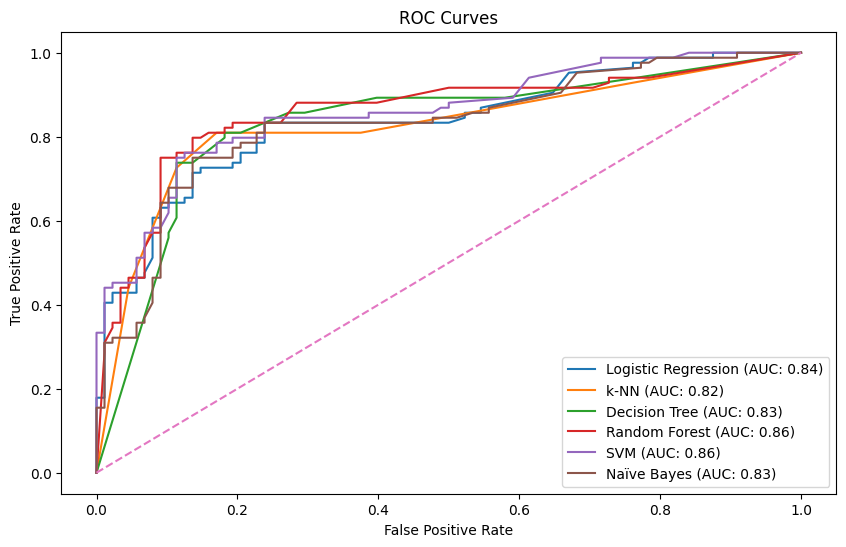

In [20]:
results = []
plt.figure(figsize=(10, 6))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else None

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else None

    results.append([name, accuracy, precision, recall, f1, roc_auc])

    # ROC Curve
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.plot(fpr, tpr, label=f'{name} (AUC: {roc_auc:.2f})')

# Plot ROC Curve
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


# Confusion Matrix & Final Results

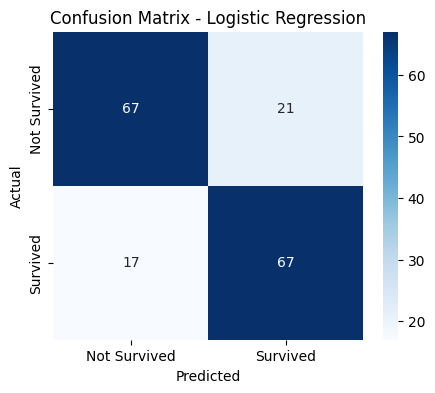

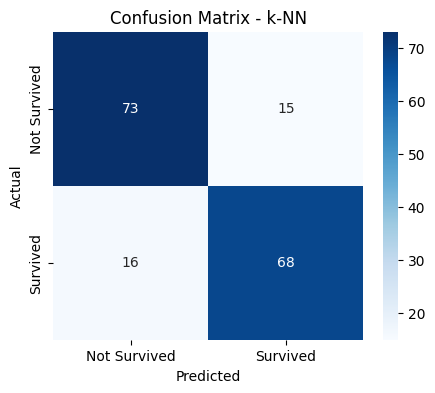

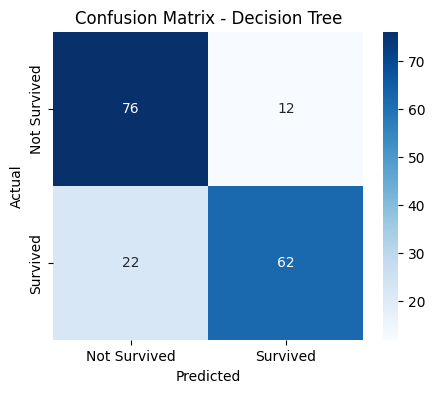

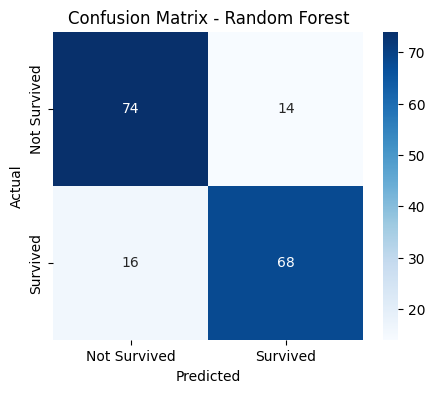

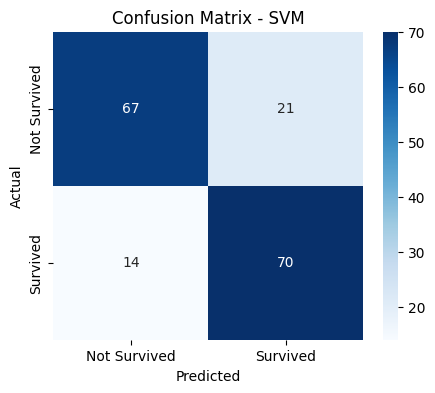

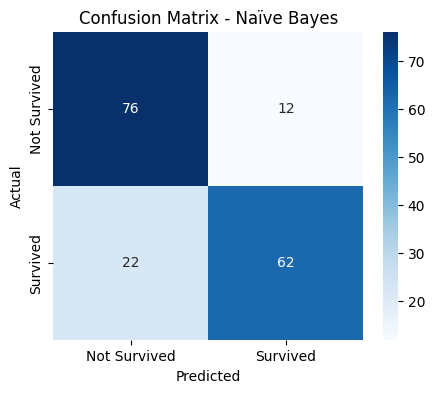

In [21]:
for name, clf in classifiers.items():
    y_pred = clf.predict(X_test)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {name}')
    plt.show()


# Performance Summary

In [22]:
# Create performance comparison table
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])
print(results_df.sort_values(by='Accuracy', ascending=False))

# Identify best model
print("\n--- Performance Comparison Summary ---")
best_model = results_df.sort_values(by='Accuracy', ascending=False).iloc[0]['Model']
print(f"Best model based on accuracy: {best_model}\n")


                 Model  Accuracy  Precision    Recall  F1-score   ROC-AUC
3        Random Forest  0.825581   0.829268  0.809524  0.819277  0.857752
1                 k-NN  0.819767   0.819277  0.809524  0.814371  0.824878
5          Naïve Bayes  0.802326   0.837838  0.738095  0.784810  0.829748
2        Decision Tree  0.802326   0.837838  0.738095  0.784810  0.831439
4                  SVM  0.796512   0.769231  0.833333  0.800000  0.859375
0  Logistic Regression  0.779070   0.761364  0.797619  0.779070  0.836377

--- Performance Comparison Summary ---
Best model based on accuracy: Random Forest

